## Time Series Forecasting using Sarimax Model in Python.


Time series is a sequence of data recorded over a certain regular period of time. Time series is used to forecasting time-dependent data. There are different statistical methods used in time series forecasting like ARIMA, SARIMAX ,HoltWinters, and deep learning neural network like LSTM. In this notebook, we'll use Seasonal version of ARIMA model called SARIMAX model.

In [1]:
import pandas as pd
import numpy as np
import statsmodels
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error


The data can be found in this link https://www.kaggle.com/datasets/hsankesara/portland-oregon-avg-rider-monthly-data

In [2]:
data = pd.read_csv('portland-oregon-average-monthly-.csv')

### Exploratory Data Analysis to understand the data.

Checking the first five rows of the data


In [3]:
data.head()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [4]:
data.shape

(115, 2)

In [6]:
data.head(2)

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646


#### Changing the column names.

In [7]:
data.columns = ['Month', 'Riders']

In [8]:
data.head()

,Month,Riders
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [9]:
data.dtypes

Month     object
Riders    object
dtype: object

In [10]:
data.tail()

,Month,Riders
110,1969-03,1419
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,Portland Oregon average monthly bus ridership ...,n=114


The last row of the data is not part of the data. So, we want to drop it from the dataframe.

In [11]:
data.drop(114, axis=0, inplace=True)

The datatypes are both object, but we want the month column to be a datetime and the Riders column should be an integer. We are converting the datatypes.

In [12]:
data['Riders'] = data['Riders'].astype('int')
data['Month'] = pd.to_datetime(data['Month'])

In [13]:
data.dtypes

Month     datetime64[ns]
Riders             int32
dtype: object

 We need to set the month as the index. This is important in time series. 

In [14]:
data.set_index('Month', inplace=True)

In [15]:
data.shape

(114, 1)

In [16]:
data.head()

,Riders
Month,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


In [17]:
data.tail()

,Riders
Month,
1969-02-01,1425
1969-03-01,1419
1969-04-01,1432
1969-05-01,1394
1969-06-01,1327


In [18]:
data.describe()

,Riders
count,114.000000
mean,1120.543860
std,270.888317
min,613.000000
25%,885.000000
50%,1158.000000
75%,1340.000000
max,1558.000000


### Visualize the data in a plot and also use seasonal decompose library to separate the trend and seasonality in the data if any.

<AxesSubplot:xlabel='Month'>

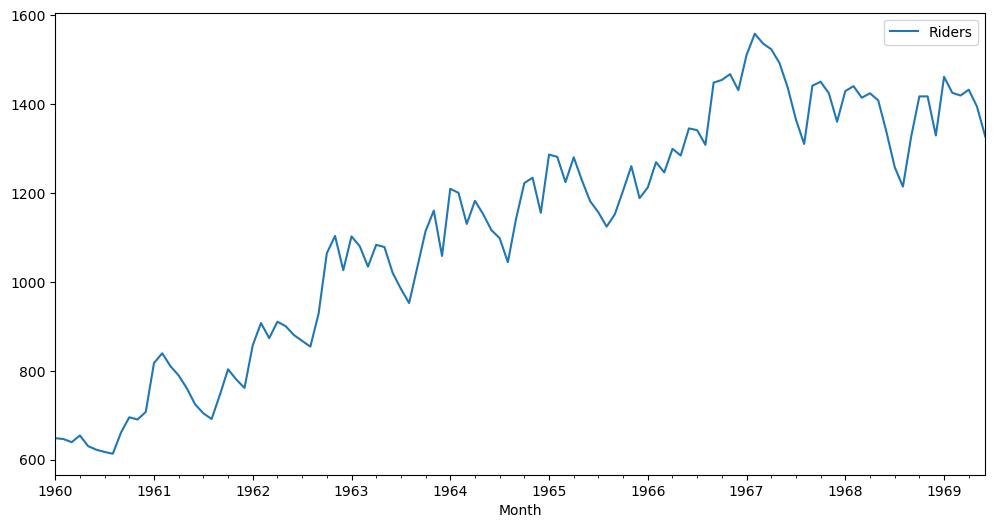

In [19]:
data.plot(figsize=(12,6))

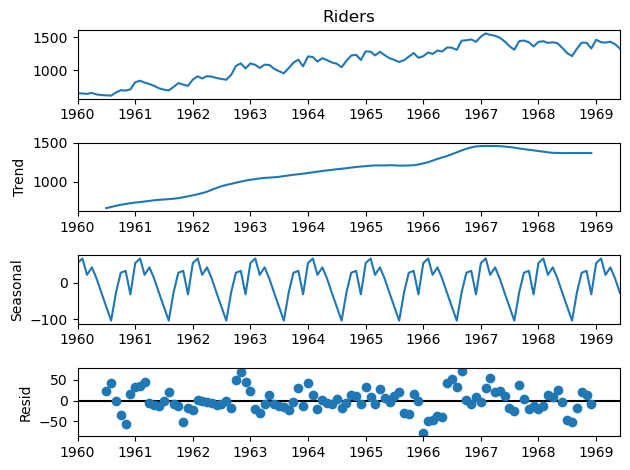

In [20]:
results = seasonal_decompose(data['Riders']);
results.plot();    

### Check if data is stationary

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.

In [22]:
def adfuller_test(riders):
    result = adfuller(riders)
    labels = ['ADF Test Statistic', 'p-value','#Lags used', 'Number of Observations used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('strong evidence against the null hypothesis(Ho), reject the null hypothesis, data is stationary')
    else:
        print('weak evidence against the null hypothesis(Ho), data is not stationary')

In [23]:
 adfuller_test(data['Riders'])

ADF Test Statistic : -1.536597144453159
p-value : 0.5153358797821738
#Lags used : 12
Number of Observations used : 101
weak evidence against the null hypothesis(Ho), data is not stationary


### Differencing

Differencing is a method used to make a data stationary. 

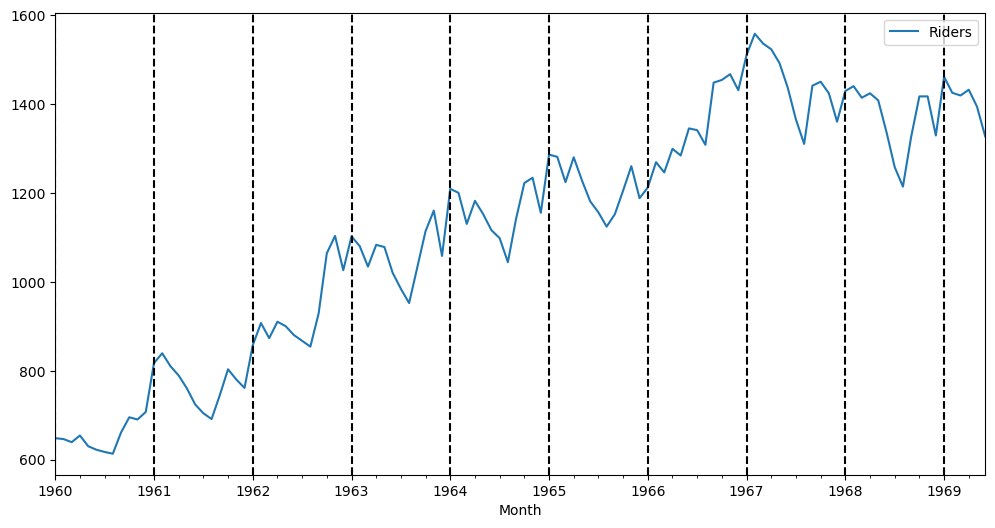

In [24]:
ax = data.plot(figsize=(12,6))

xcoords = ['1960-01-01', '1961-01-01','1962-01-01', '1963-01-01', '1964-01-01', '1965-01-01',
          '1966-01-01', '1967-01-01', '1968-01-01', '1969-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

### Plotting the Autocorrelation and Partial Autocorrelation.

This helps us to determine the appropriate values of p, d, and q.

C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


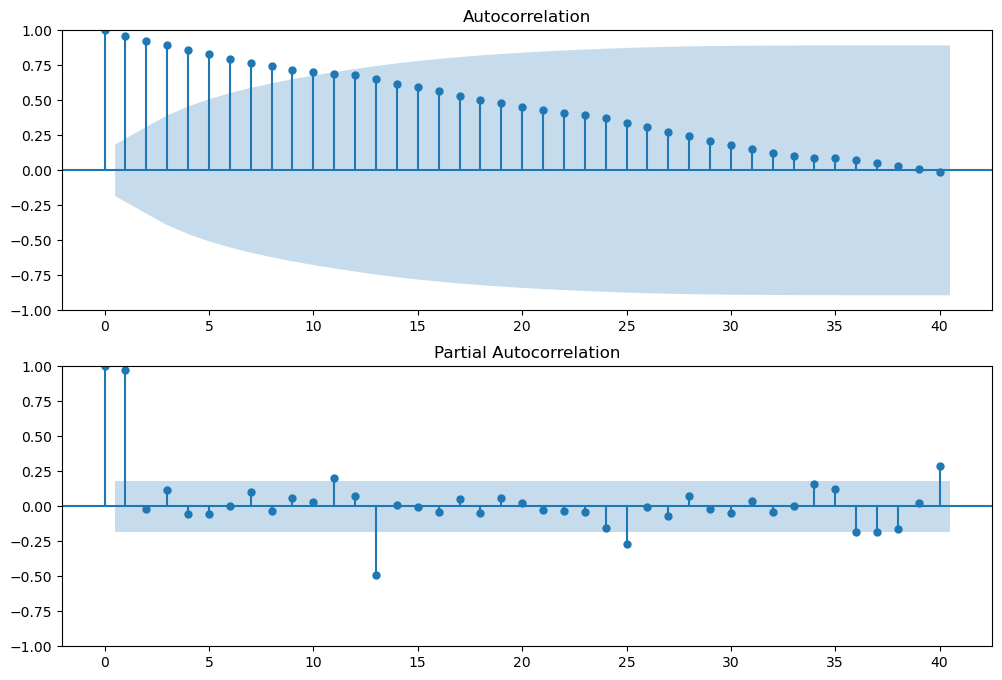

In [25]:
testing = data['Riders'].dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(testing, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(testing, lags=40, ax=ax2)

Finding the difference between the data points and the data points of te previous 12th month. We use panda's .shift method to schieve this. 

In [63]:
data['Seasonal_1st_diff'] = data['Riders'] - data['Riders'].shift(12)

In [64]:
data.head(20)

,Riders,Seasonal_1st_diff,forecast
Month,,,
1960-01-01,648,NaN,NaN
1960-02-01,646,NaN,NaN
1960-03-01,639,NaN,NaN
1960-04-01,654,NaN,NaN
1960-05-01,630,NaN,NaN
1960-06-01,622,NaN,NaN
1960-07-01,617,NaN,NaN
1960-08-01,613,NaN,NaN
1960-09-01,661,NaN,NaN


We want to check the data again after differencing to see if it is stationary after the differencing.

In [65]:
 adfuller_test(data['Seasonal_1st_diff'].dropna())

ADF Test Statistic : -2.4697405635319676
p-value : 0.1230114153404816
#Lags used : 3
Number of Observations used : 98
weak evidence against the null hypothesis(Ho), data is not stationary


<AxesSubplot:xlabel='Month'>

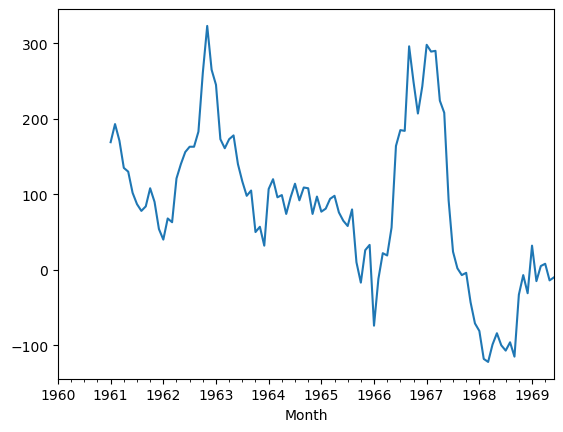

In [66]:
data['Seasonal_1st_diff'].plot()

The data is still not stationary.

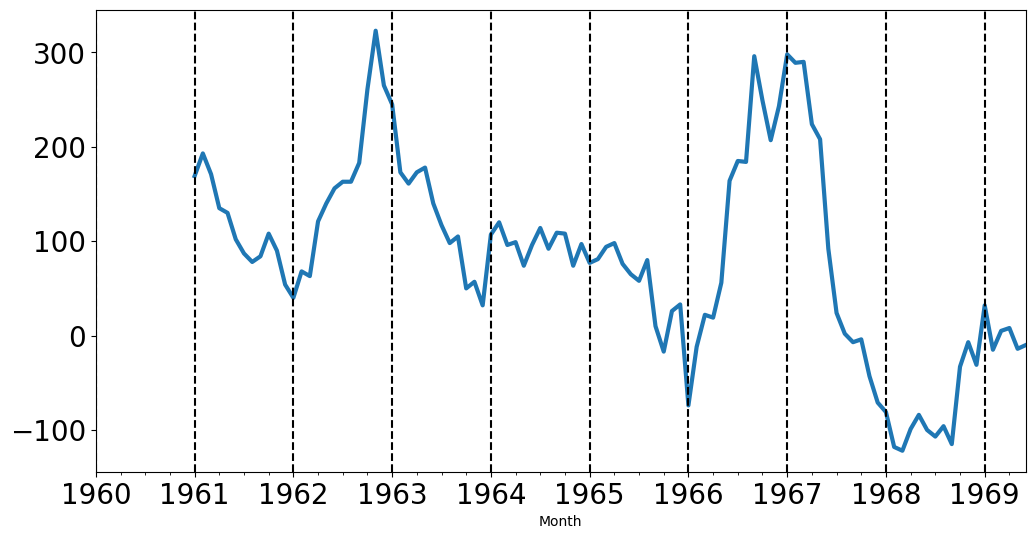

In [67]:
ax = data['Seasonal_1st_diff'].plot(figsize=(12,6), linewidth=3, fontsize=20)

xcoords = ['1960-01-01', '1961-01-01','1962-01-01', '1963-01-01', '1964-01-01', '1965-01-01',
          '1966-01-01', '1967-01-01', '1968-01-01', '1969-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

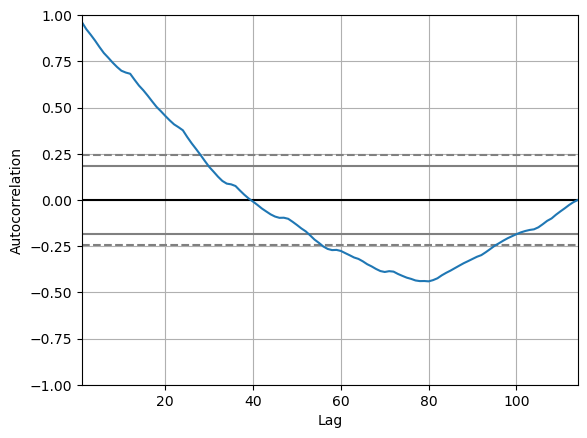

In [48]:
autocorrelation_plot(data['Riders'])
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

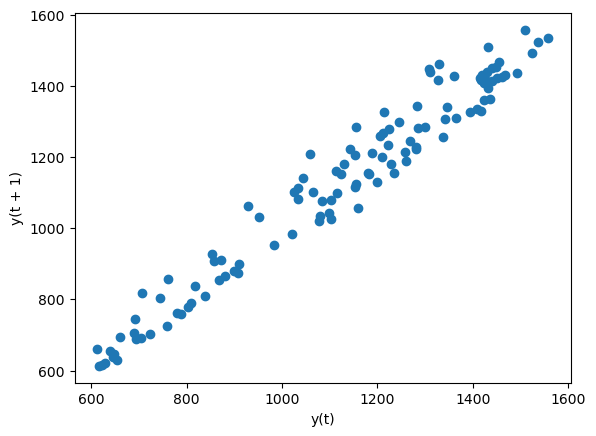

In [46]:
pd.plotting.lag_plot(data['Riders'])

# Finding p,q,and d values with pmdarima

From the autocorrelation plots of the data both before and after differencing, it's difficult to determine the values of p, q and d for our arima/sarima model. To this end, we'll use pmdarima library to help us find their values.

In another notebook, we'll use the Holt-Winter's model, which is more suitable and straightforward for data with trend and seasonality, to build model and forecast for this same data

In [33]:
stepwise_fit = auto_arima(data['Riders'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1235.799, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1236.989, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1238.600, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1238.277, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1236.254, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1234.903, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1233.580, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1235.475, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1234.436, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1232.853, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1234.568, Time=0.96 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1236.809, Time=0.50 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1

In [34]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -610.427
Date:                Mon, 21 Nov 2022   AIC                           1232.853
Time:                        14:01:46   BIC                           1249.218
Sample:                    01-01-1960   HQIC                          1239.494
                         - 06-01-1969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.4050      6.822      1.965      0.049       0.034      26.776
ar.L1         -0.9972      0.032    -30.792      0.000      -1.061      -0.934
ma.L1          0.9839      0.107      9.218      0.000       0.775       1.193
ma.L2         -0.3987      0.137     -2.917      0.004      -0.666      -0.131
ma.L3         -0.3985      0.104     -3.834      0.000      -0.602      -0.195
sigma2      2847.1340    499.422      5.701      0.000    1868.285    3825.984
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 6.15
Prob(Q):                              0.86   Prob(JB):                         0.05
Heteroskedasticity (H):               1.84   Skew:                             0.57
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting the autocorrelation and partial autocorrelation plot of the seasonal data.

C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


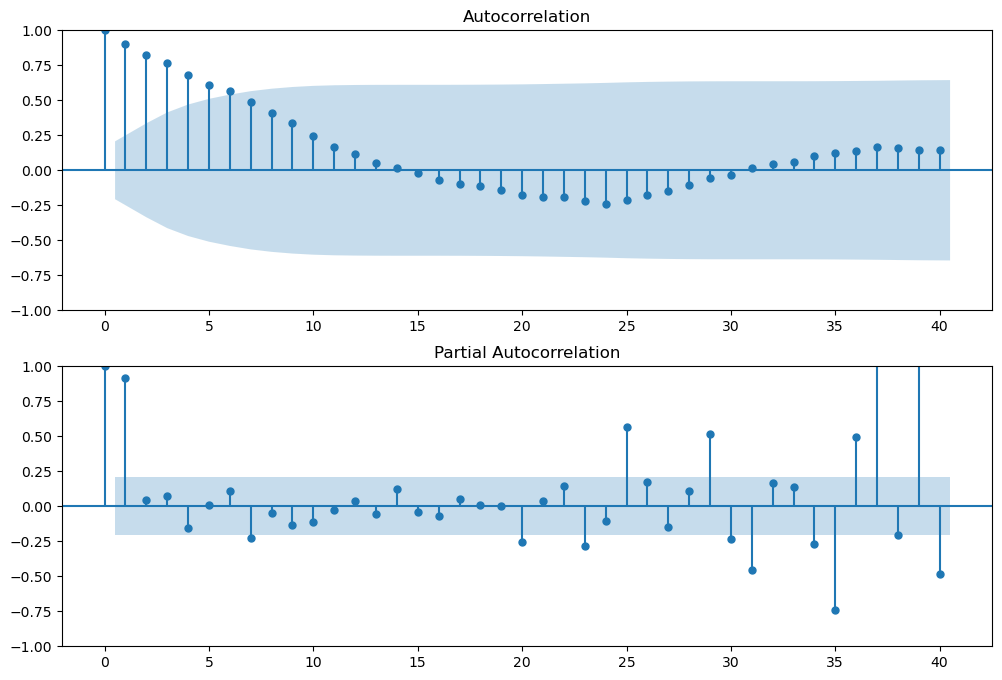

In [35]:
seasonal = data['Seasonal_1st_diff'].dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal, lags=40, ax=ax2)

### Sarimax model.

Since we noticed a seasonality in our data and differencing was unable to make the data stationary, we'll use SARIMAX model for this time series.

In [61]:

model = sm.tsa.statespace.SARIMAX(data['Riders'], order=(1,1,3), seasonal_order = (1,1,3,12))
results = model.fit()

C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Surface\anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

Predicting the number of riders for the last 24 months of the data.

<AxesSubplot:xlabel='Month'>

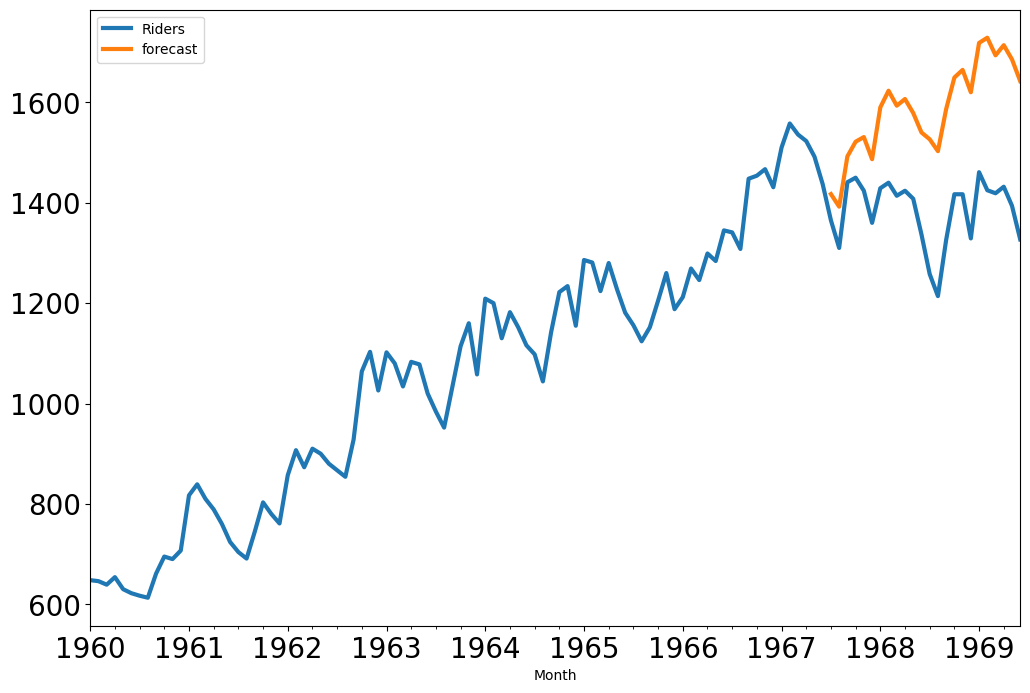

In [62]:
data['forecast'] = results.predict(start=90, end=114, dynamic=True)
data[['Riders', 'forecast']].plot(figsize=(12,8), linewidth=3, fontsize=20)

We want to generate the corresponding dates for the next 24 months and predict the expected number of riders for the 24 months.

In [38]:
future_dates = [data.index[-1]+ DateOffset(months=x) for x in range(0,24)]

In [39]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=data.columns)

In [40]:
future_dates_df.tail()

,Riders,Seasonal_1st_diff,forecast
1971-01-01,NaN,NaN,NaN
1971-02-01,NaN,NaN,NaN
1971-03-01,NaN,NaN,NaN
1971-04-01,NaN,NaN,NaN
1971-05-01,NaN,NaN,NaN


Combining the forecast with the original data frame .

In [41]:
future_data = pd.concat([data, future_dates_df])
future_data

,Riders,Seasonal_1st_diff,forecast
1960-01-01,648,NaN,NaN
1960-02-01,646,NaN,NaN
1960-03-01,639,NaN,NaN
1960-04-01,654,NaN,NaN
1960-05-01,630,NaN,NaN
...,...,...,...
1971-01-01,NaN,NaN,NaN
1971-02-01,NaN,NaN,NaN
1971-03-01,NaN,NaN,NaN
1971-04-01,NaN,NaN,NaN


Plotting the original data and the prediction for the next 24 months.

<AxesSubplot:>

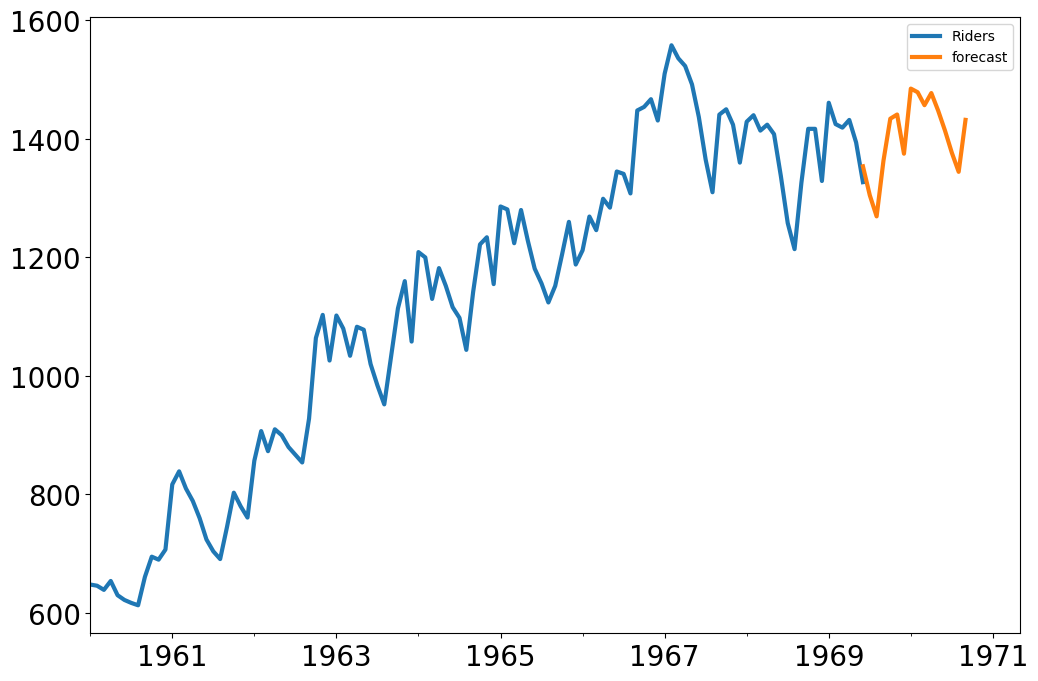

In [44]:
future_data['forecast'] =  results.predict(start=113, end=128, dynamic=True)
future_data[['Riders', 'forecast']].plot(figsize=(12,8), linewidth=3, fontsize=20)